## 1. Importación de Librerías



In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import random
import os
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras import models
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array
import visualkeras

In [2]:
# Ejecutar una sola vez para descargar las capertas donde viene el dataset
# Y una vez descargado movemos las carpetas de Testing y Training a Nuestra carpeta donde
# vamos a estar trabajando

#import kagglehub

# Download latest version
#path = kagglehub.dataset_download("masoudnickparvar/brain-tumor-mri-dataset")

#print("Path to dataset files:", path)

## 2. Configuración de la Semilla para Reproducibilidad

In [3]:
# Establecer una semilla nos ayuda a obtener los mismos resultados cada vez que ejecutamos el código.
# Es crucial para la depuración y para comparar el rendimiento de diferentes modelos de manera justa.
seed_value = 42


random.seed(seed_value)


np.random.seed(seed_value)


tf.random.set_seed(seed_value)

os.environ['TF_DETERMINISTIC_OPS'] = '1'

print(f"Semillas de aleatoriedad fijadas en: {seed_value}")
CLASS_TYPES = ['pituitary', 'notumor', 'meningioma', 'glioma']
N_TYPES = len(CLASS_TYPES)

Semillas de aleatoriedad fijadas en: 42


## 3. Carga y Preprocesamiento de Datos

In [4]:
# Definir las rutas a los directorios de entrenamiento y prueba
train_dir = 'Training/'
test_dir = 'Testing/'

# --- Definir constantes para el preprocesamiento ---
IMG_SIZE = (150, 150) # Tamaño estándar para todas las imágenes
BATCH_SIZE = 32       # Número de imágenes a procesar en cada lote
# La variable seed_value se definió en la celda anterior para garantizar la reproducibilidad
SEED = seed_value

# --- Data Augmentation---

train_datagen = ImageDataGenerator(
    rescale=1./255,                 # Normaliza los pixeles de las imágenes a un rango de [0, 1]
    rotation_range=10,              # Gira las imágenes aleatoriamente hasta 10 grados
    brightness_range=(0.85, 1.15),  # Cambia el brillo de la imagen aleatoriamente
    width_shift_range=0.002,        # Desplaza las imágenes horizontalmente (un valor muy pequeño)
    height_shift_range=0.002,       # Desplaza las imágenes verticalmente (un valor muy pequeño)
    shear_range=12.5,               # Aplica cortes (transformaciones de cizallamiento)
    zoom_range=0,                   # No se aplica zoom aleatorio
    horizontal_flip=True,           # Invierte las imágenes horizontalmente
    vertical_flip=False,            # No se invierten las imágenes verticalmente
    fill_mode="nearest"             # Rellena los nuevos pixeles que puedan aparecer
)

# --- Generador de Datos de Prueba ---
# Para el conjunto de prueba, solo necesitamos normalizar los pixeles.
test_datagen = ImageDataGenerator(rescale=1./255)


# --- Aplicar los generadores a los datos ---
# Usamos flow_from_directory para cargar las imágenes, inferir las clases y aplicar las transformaciones.
# Se utiliza la semilla (SEED) para que el barajado y las transformaciones sean reproducibles.
print("Cargando datos de entrenamiento...")
training_set = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    seed=SEED
)

print("Cargando datos de prueba...")
testing_set = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False, # Es importante no barajar los datos de prueba para una evaluación consistente
    seed=SEED
)

# Imprimir las clases encontradas
print("Clases encontradas en el conjunto de entrenamiento:")
print(training_set.class_indices)

Cargando datos de entrenamiento...
Found 5712 images belonging to 4 classes.
Cargando datos de prueba...
Found 1311 images belonging to 4 classes.
Clases encontradas en el conjunto de entrenamiento:
{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}


## 4. Visualización de los Datos Cargados

C:\Users\nefth\AppData\Local\Temp\ipykernel_18128\3595134254.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(train_counts.keys()), y=list(train_counts.values()), ax=ax1, palette="viridis")
C:\Users\nefth\AppData\Local\Temp\ipykernel_18128\3595134254.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(test_counts.keys()), y=list(test_counts.values()), ax=ax2, palette="plasma")


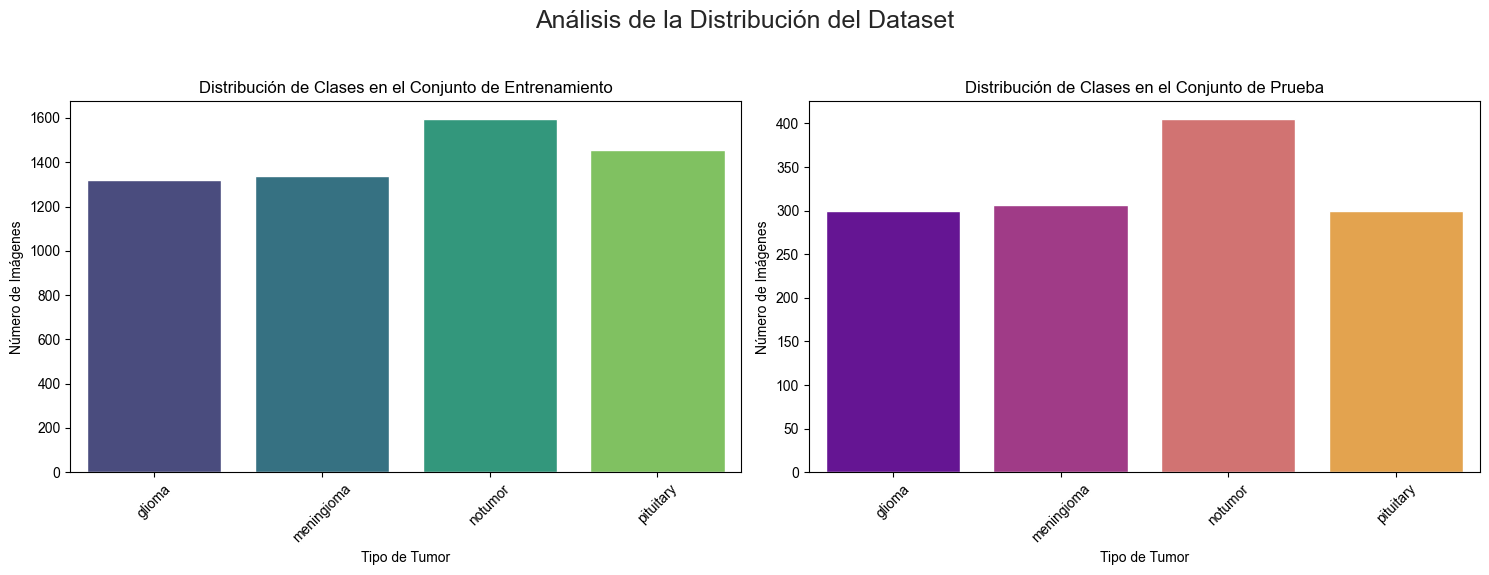

In [5]:
# Función para contar imágenes en cada subdirectorio
def count_images(directory):
    counts = {}
    for subdir in os.listdir(directory):
        if os.path.isdir(os.path.join(directory, subdir)):
            counts[subdir] = len(os.listdir(os.path.join(directory, subdir)))
    return counts

# Contar imágenes en los conjuntos de entrenamiento y prueba
train_counts = count_images(train_dir)
test_counts = count_images(test_dir)

# Crear los gráficos de barras
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
sns.set_style("whitegrid")

# Gráfico para el conjunto de entrenamiento
sns.barplot(x=list(train_counts.keys()), y=list(train_counts.values()), ax=ax1, palette="viridis")
ax1.set_title('Distribución de Clases en el Conjunto de Entrenamiento')
ax1.set_xlabel('Tipo de Tumor')
ax1.set_ylabel('Número de Imágenes')
ax1.tick_params(axis='x', rotation=45)

# Gráfico para el conjunto de prueba
sns.barplot(x=list(test_counts.keys()), y=list(test_counts.values()), ax=ax2, palette="plasma")
ax2.set_title('Distribución de Clases en el Conjunto de Prueba')
ax2.set_xlabel('Tipo de Tumor')
ax2.set_ylabel('Número de Imágenes')
ax2.tick_params(axis='x', rotation=45)

plt.suptitle('Análisis de la Distribución del Dataset', fontsize=18)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

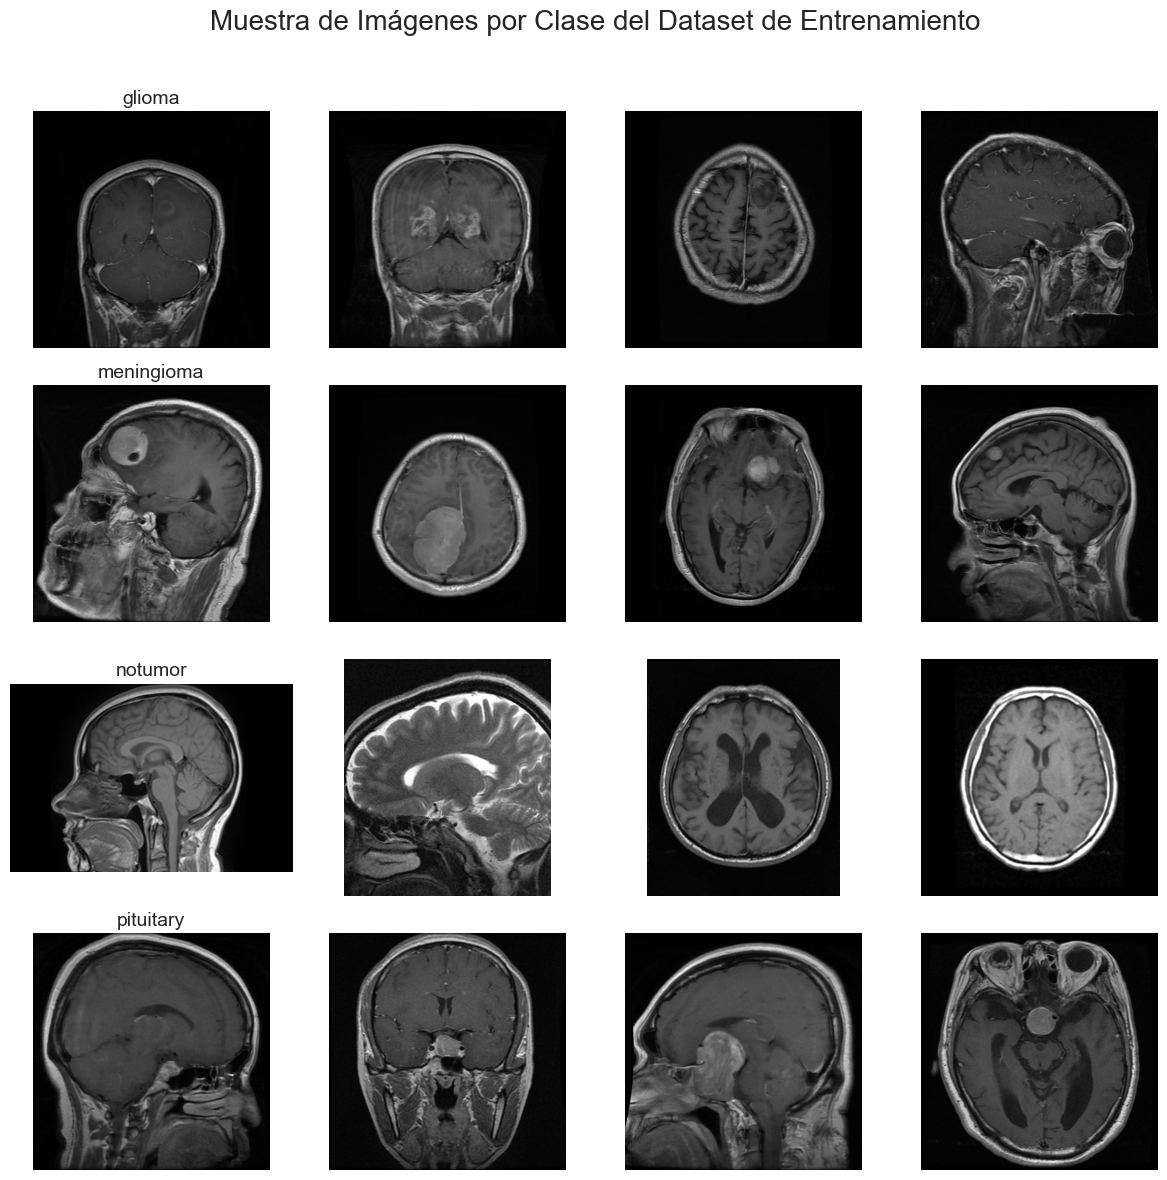

In [6]:
from tensorflow.keras.preprocessing.image import load_img
import random

# Obtener las clases del generador de datos
class_labels = list(training_set.class_indices.keys())

# Crear una figura para mostrar 4x4 imágenes
fig, axes = plt.subplots(4, 4, figsize=(12, 12))
fig.suptitle('Muestra de Imágenes por Clase del Dataset de Entrenamiento', fontsize=20)

for i, label in enumerate(class_labels):
    # Ruta al directorio de la clase
    class_dir = os.path.join(train_dir, label)
    
    # Obtener una lista de imágenes y barajarla para obtener muestras aleatorias
    image_files = os.listdir(class_dir)
    random.shuffle(image_files)
    
    # Mostrar las primeras 4 imágenes de la lista barajada
    for j in range(4):
        if j < len(image_files):
            img_path = os.path.join(class_dir, image_files[j])
            img = load_img(img_path)
            
            ax = axes[i, j]
            ax.imshow(img)
            ax.axis('off')
            # Poner el nombre de la clase como título de la primera imagen de cada fila
            if j == 0:
                ax.set_title(label, fontsize=14)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

## 5. Definición de las Arquitecturas de los Modelos (CNN)

### Modelo 1: Arquitectura Profunda

Arquitectura del Modelo 1:


c:\Users\nefth\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 147, 147, 32)   │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 49, 49, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 46, 46, 64)     │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 15, 15, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 128)    │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 1, 1, 256)      │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 823,780 (3.14 MB)

 Trainable params: 823,780 (3.14 MB)

 Non-trainable params: 0 (0.00 B)

c:\Users\nefth\AppData\Local\Programs\Python\Python312\Lib\site-packages\visualkeras\layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


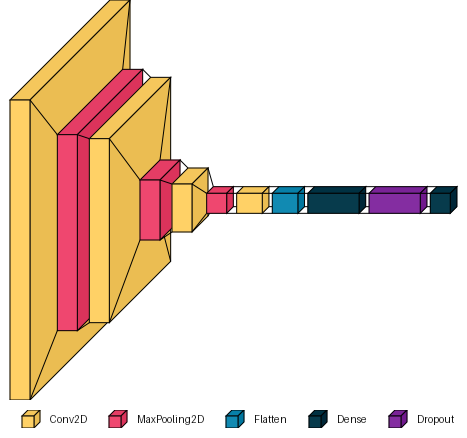

In [7]:
def build_model_1():
    # IMG_SIZE = (150, 150), seed_value = 42, y tenemos 4 clases de tumores.
    image_shape = (IMG_SIZE[0], IMG_SIZE[1], 3)
    num_classes = 4

    # Define la arquitectura del modelo
    model = models.Sequential()

    # Capa Convolucional 1
    model.add(Conv2D(32, (4, 4), activation="relu", input_shape=image_shape))
    model.add(MaxPooling2D(pool_size=(3, 3)))

    # Capa Convolucional 2
    model.add(Conv2D(64, (4, 4), activation="relu"))
    model.add(MaxPooling2D(pool_size=(3, 3)))

    # Capa Convolucional 3
    model.add(Conv2D(128, (4, 4), activation="relu"))
    model.add(MaxPooling2D(pool_size=(3, 3)))

    # Capa Convolucional 4
    model.add(Conv2D(256, (4, 4), activation="relu"))

    # Aplanar los mapas de características para la capa densa
    model.add(Flatten())

    # Capas totalmente conectadas (Dense) para la clasificación
    model.add(Dense(512, activation="relu"))
    # Añadimos Dropout para regularización, usando nuestra semilla para reproducibilidad
    model.add(Dropout(0.5, seed=seed_value))
    # Capa de salida con una neurona por cada clase y activación softmax
    model.add(Dense(num_classes, activation="softmax"))

    # Compilamos el modelo con un optimizador, función de pérdida y métricas
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model


model_1 = build_model_1()
print("Arquitectura del Modelo 1:")
model_1.summary()
visualkeras.layered_view(model_1, legend=True, max_xy=300)

### Modelo 2: Arquitectura con Dropout

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 147, 147, 32)   │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 73, 73, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 70, 70, 64)     │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 35, 35, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 32, 32, 128)    │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │    16,777,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,945,380 (64.64 MB)

 Trainable params: 16,945,380 (64.64 MB)

 Non-trainable params: 0 (0.00 B)

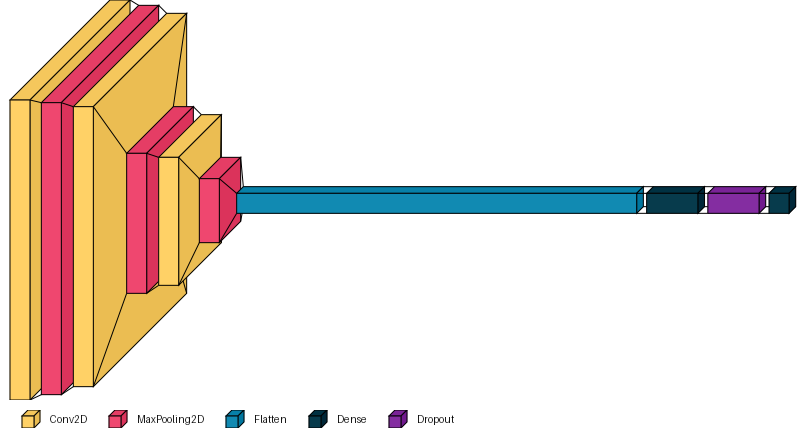

In [8]:
def build_model_2():
    model = tf.keras.models.Sequential([
        Conv2D(32, (4, 4), activation='relu', input_shape=(150, 150, 3)),
        MaxPooling2D(2, 2),

        Conv2D(64, (4, 4), activation='relu'),
        MaxPooling2D(2, 2),

        Conv2D(128, (4, 4), activation='relu'),
        MaxPooling2D(2, 2),

        Flatten(),
        Dense(512, activation='relu'),
        # Capa Dropout: "Apaga" el 50% de las neuronas para prevenir el sobreajuste.
        Dropout(0.5),
        Dense(4, activation='softmax')
    ])

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

model_2 = build_model_2()
model_2.summary()
visualkeras.layered_view(model_2, legend=True, max_xy=300)

### Modelo 3: Arquitectura Profunda


--- Arquitectura Modelo 3 (con Batch Normalization) ---


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Conv1_M3 (Conv2D)               │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN1_M3 (BatchNormalization)     │ (None, 148, 148, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Pool1_M3 (MaxPooling2D)         │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv2_M3 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN2_M3 (BatchNormalization)     │ (None, 72, 72, 64)     │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Pool2_M3 (MaxPooling2D)         │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv3_M3 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN3_M3 (BatchNormalization)     │ (None, 34, 34, 128)    │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Pool3_M3 (MaxPooling2D)         │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Flatten_M3 (Flatten)            │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_M3 (Dense)                │ (None, 512)            │    18,940,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ BN4_M3 (BatchNormalization)     │ (None, 512)            │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dropout_M3 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output_M3 (Dense)               │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,038,660 (72.63 MB)

 Trainable params: 19,037,188 (72.62 MB)

 Non-trainable params: 1,472 (5.75 KB)

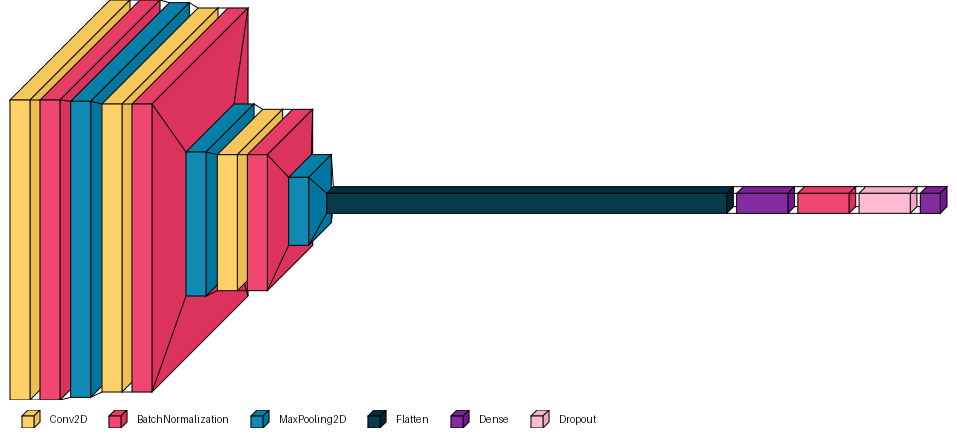

In [ ]:
from tensorflow.keras.layers import BatchNormalization
def build_model_3():
    """
    Define una arquitectura completamente nueva para el Modelo 3,
    caracterizada por el uso intensivo de Batch Normalization.
    """
    image_shape = (IMG_SIZE[0], IMG_SIZE[1], 3)
    num_classes = 4
    
    model = models.Sequential([
        # Bloque 1
        Conv2D(32, (3, 3), activation='relu', input_shape=image_shape, name="Conv1_M3"),
        BatchNormalization(name="BN1_M3"), 
        MaxPooling2D(pool_size=(2, 2), name="Pool1_M3"),

        # Bloque 2
        Conv2D(64, (3, 3), activation='relu', name="Conv2_M3"),
        BatchNormalization(name="BN2_M3"), 
        MaxPooling2D(pool_size=(2, 2), name="Pool2_M3"),

        # Bloque 3
        Conv2D(128, (3, 3), activation='relu', name="Conv3_M3"),
        BatchNormalization(name="BN3_M3"), 
        MaxPooling2D(pool_size=(2, 2), name="Pool3_M3"),

        # Aplanar y clasificar
        Flatten(name="Flatten_M3"),
        
        # Bloque denso
        Dense(512, activation='relu', name="Dense_M3"),
        BatchNormalization(name="BN4_M3"),
        Dropout(0.5, name="Dropout_M3"),
        
        # Capa de salida
        Dense(num_classes, activation='softmax', name="Output_M3")
    ])

   
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.869, beta_2=0.995)
    
    model.compile(optimizer=optimizer, 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    
    return model


model_3 = build_model_3()


print("\n--- Arquitectura Modelo 3 (con Batch Normalization) ---")
model_3.summary()
visualkeras.layered_view(model_3, legend=True, max_xy=300)

## 6. Entrenamiento y Evaluación de los Modelos

In [10]:
# Entrenamos el modelo usando los generadores de datos que creamos.
# epochs es el número de veces que el modelo verá el conjunto de datos completo.

print("Entrenando el Modelo 1...")
history_1 = model_1.fit(
    training_set,
    epochs=20, 
    validation_data=testing_set
)
print("Entrenando el Modelo 2...")
history_2 = model_2.fit(
    training_set,
    epochs=20, 
    validation_data=testing_set
)
print("Entrenando el Modelo 3...")
history_3 = model_3.fit(
    training_set,
    epochs=20, 
    validation_data=testing_set
)

Entrenando el Modelo 1...


c:\Users\nefth\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 33s 180ms/step - accuracy: 0.5133 - loss: 1.0090 - val_accuracy: 0.7353 - val_loss: 0.6857
Epoch 2/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 30s 165ms/step - accuracy: 0.7795 - loss: 0.5453 - val_accuracy: 0.7818 - val_loss: 0.5560
Epoch 3/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 29s 165ms/step - accuracy: 0.8377 - loss: 0.4341 - val_accuracy: 0.8200 - val_loss: 0.4583
Epoch 4/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 30s 165ms/step - accuracy: 0.8566 - loss: 0.3701 - val_accuracy: 0.8192 - val_loss: 0.4438
Epoch 5/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 30s 167ms/step - accuracy: 0.8876 - loss: 0.2982 - val_accuracy: 0.8909 - val_loss: 0.2975
Epoch 6/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 29s 164ms/step - accuracy: 0.9278 - loss: 0.1981 - val_accuracy: 0.8940 - val_loss: 0.2578
Epoch 7/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 29s 165ms/step - accuracy: 0.9346 - loss: 0.1747 - val_accuracy: 0.9436 - val_loss: 0.1559
Epoch 8/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 30s 165ms/step - accuracy: 0.9494 - loss: 0

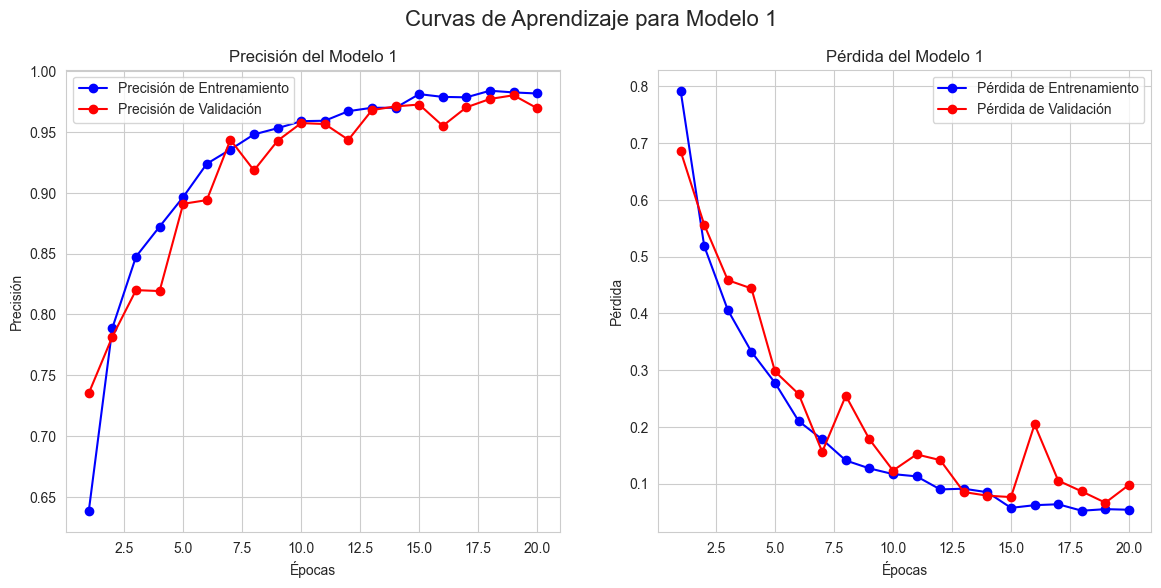

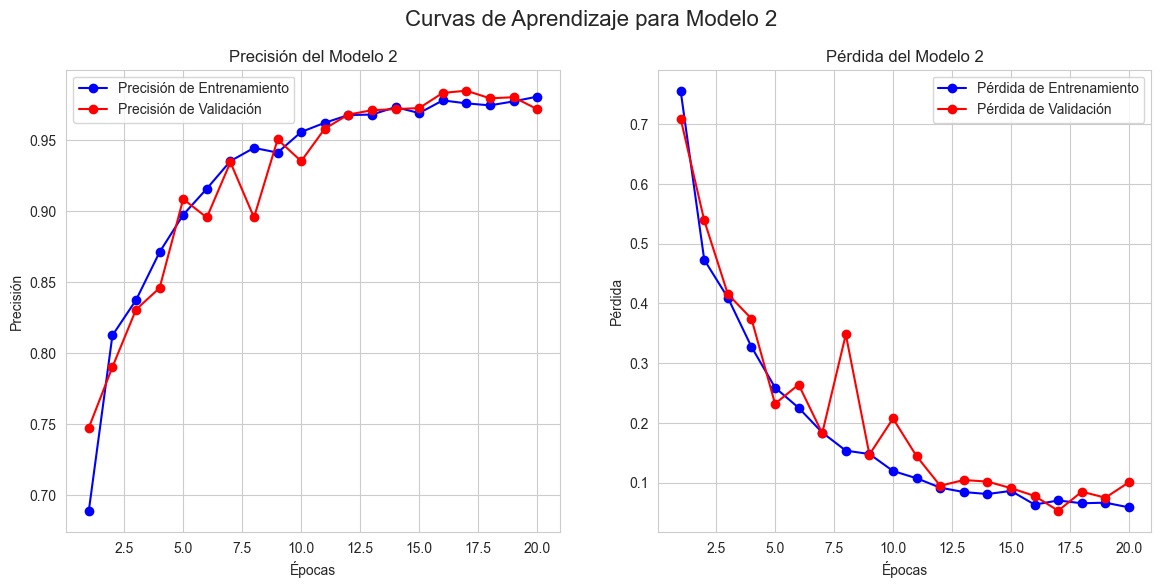

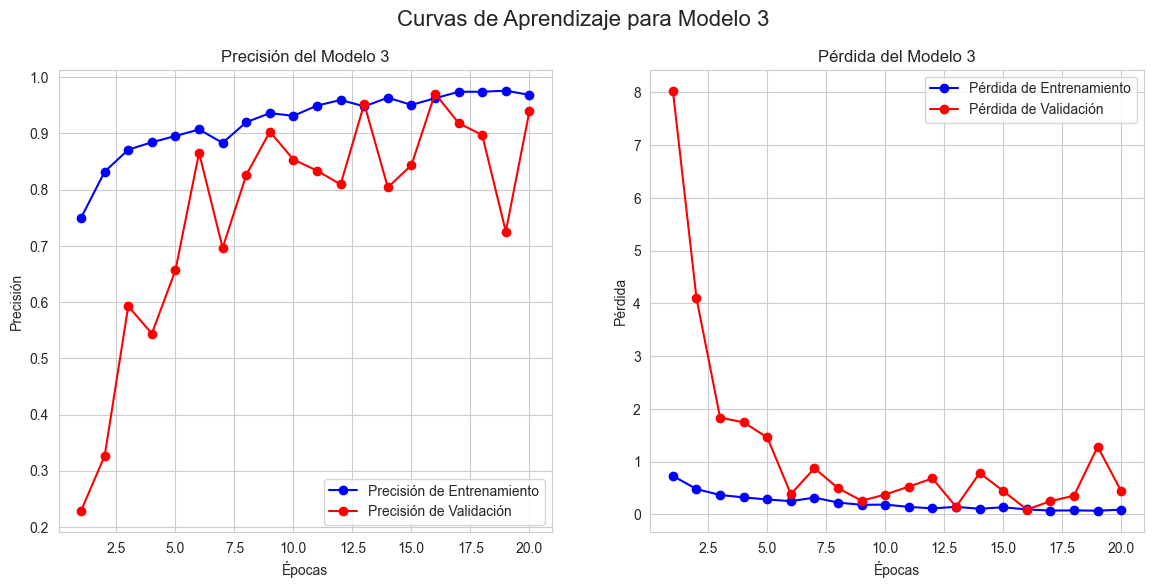

In [11]:
def plot_training_history(history, model_name):
    """
    Función para graficar la precisión y la pérdida de entrenamiento y validación.
    """
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(14, 6))

    # Gráfica de Precisión
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo-', label='Precisión de Entrenamiento')
    plt.plot(epochs, val_acc, 'ro-', label='Precisión de Validación')
    plt.title(f'Precisión del {model_name}')
    plt.xlabel('Épocas')
    plt.ylabel('Precisión')
    plt.grid(True)
    plt.legend()

    # Gráfica de Pérdida
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo-', label='Pérdida de Entrenamiento')
    plt.plot(epochs, val_loss, 'ro-', label='Pérdida de Validación')
    plt.title(f'Pérdida del {model_name}')
    plt.xlabel('Épocas')
    plt.ylabel('Pérdida')
    plt.grid(True)
    plt.legend()

    plt.suptitle(f'Curvas de Aprendizaje para {model_name}', fontsize=16)
    plt.show()

plot_training_history(history_1, "Modelo 1")
plot_training_history(history_2, "Modelo 2")
plot_training_history(history_3, "Modelo 3")

## 7. Evaluación Final Comparativa

In [12]:
print("Evaluando el rendimiento final del modelo en el conjunto de prueba...")


loss, accuracy = model_1.evaluate(testing_set)
print("Modelo 1")
print(f"Pérdida en el conjunto de prueba: {loss:.4f}")
print(f"Precisión en el conjunto de prueba: {accuracy*100:.2f}%")
loss, accuracy = model_2.evaluate(testing_set)
print("Modelo 2")
print(f"Pérdida en el conjunto de prueba: {loss:.4f}")
print(f"Precisión en el conjunto de prueba: {accuracy*100:.2f}%")
loss, accuracy = model_3.evaluate(testing_set)
print("Modelo 3")
print(f"Pérdida en el conjunto de prueba: {loss:.4f}")
print(f"Precisión en el conjunto de prueba: {accuracy*100:.2f}%")

Evaluando el rendimiento final del modelo en el conjunto de prueba...
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - accuracy: 0.9486 - loss: 0.1550
Modelo 1
Pérdida en el conjunto de prueba: 0.0977
Precisión en el conjunto de prueba: 96.95%
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - accuracy: 0.9581 - loss: 0.1473
Modelo 2
Pérdida en el conjunto de prueba: 0.1007
Precisión en el conjunto de prueba: 97.18%
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - accuracy: 0.9274 - loss: 0.4166
Modelo 3
Pérdida en el conjunto de prueba: 0.4405
Precisión en el conjunto de prueba: 93.97%


## 8. Guardar el Mejor Modelo

In [13]:
#model_2.save('brain_tumor_classifier_model_2.keras')

## 9. Probar el Modelo Guardado y Visualizar Predicciones

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
--- Predicción para una sola imagen ---
Ruta de la imagen: Testing/glioma/Te-gl_0010.jpg
El modelo predice que la clase es: 'glioma'
Confianza de la predicción: 100.00%


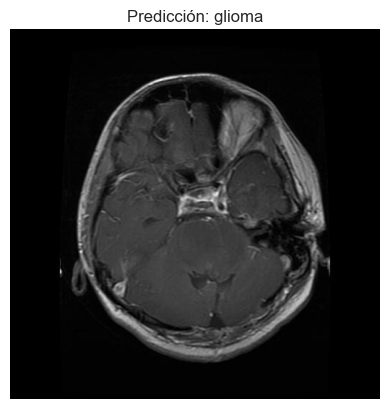

In [14]:
from tensorflow.keras.models import load_model
loaded_model = load_model('brain_tumor_classifier_model_2.keras')

class_labels = {0: 'glioma', 1: 'meningioma', 2: 'notumor', 3: 'pituitary'}


image_path = 'Testing/glioma/Te-gl_0010.jpg' 
img = load_img(image_path, target_size=(150, 150)) # Cargar y redimensionar
img_array = img_to_array(img)                      # Convertir a un array numpy
img_array = img_array / 255.0                      # Normalizar los pixeles (muy importante)
img_array = np.expand_dims(img_array, axis=0)      # Añadir una dimensión para el lote (batch)


prediction = loaded_model.predict(img_array)


predicted_class_index = np.argmax(prediction)
predicted_class_label = class_labels[predicted_class_index]
confidence = np.max(prediction) * 100

print(f"--- Predicción para una sola imagen ---")
print(f"Ruta de la imagen: {image_path}")
print(f"El modelo predice que la clase es: '{predicted_class_label}'")
print(f"Confianza de la predicción: {confidence:.2f}%")

# Mostrar la imagen de prueba
plt.imshow(load_img(image_path))
plt.title(f"Predicción: {predicted_class_label}")
plt.axis('off')
plt.show()


### Reporte de Clasificación y Matriz de Confusión

Generando predicciones para el conjunto de prueba...
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step

 --- Reporte de Clasificación ---
              precision    recall  f1-score   support

      glioma       0.99      0.96      0.97       300
  meningioma       0.95      0.97      0.96       306
     notumor       0.98      1.00      0.99       405
   pituitary       1.00      0.99      1.00       300

    accuracy                           0.98      1311
   macro avg       0.98      0.98      0.98      1311
weighted avg       0.98      0.98      0.98      1311


 --- Matriz de Confusión ---


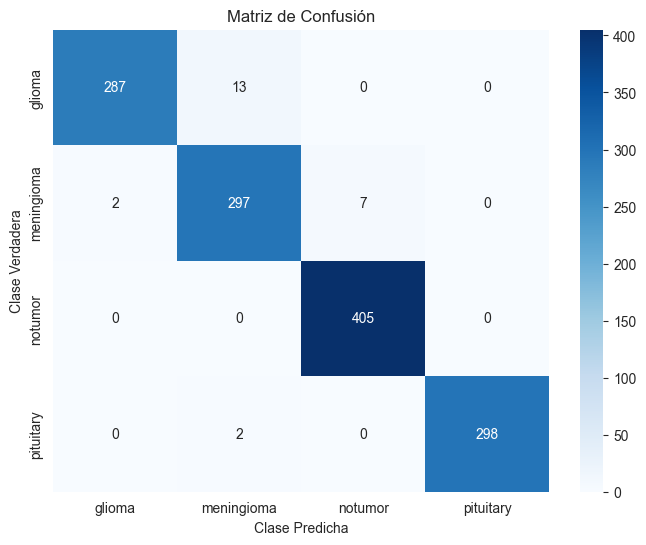

In [15]:
import numpy as np
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# 1. Obtener las predicciones para todo el conjunto de prueba
# Usamos el modelo cargado para predecir las clases de todas las imágenes en testing_set
print("Generando predicciones para el conjunto de prueba...")
predictions = loaded_model.predict(testing_set)
predicted_classes = np.argmax(predictions, axis=1)

# 2. Obtener las etiquetas verdaderas
true_classes = testing_set.classes
class_labels = list(testing_set.class_indices.keys())

# 3. Imprimir el Reporte de Clasificación
print("\n --- Reporte de Clasificación ---")
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

# 4. Generar y visualizar la Matriz de Confusión
print("\n --- Matriz de Confusión ---")
cm = confusion_matrix(true_classes, predicted_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Matriz de Confusión')
plt.ylabel('Clase Verdadera')
plt.xlabel('Clase Predicha')
plt.show()

### Ejemplos de Predicciones Correctas e Incorrectas

In [16]:
def plot_sample_predictions(model, test_generator, num_samples=9):
    # Extraer información necesaria del generador
    num_total_images = test_generator.n
    class_labels = {v: k for k, v in test_generator.class_indices.items()}
    filenames = test_generator.filenames
    test_dir = test_generator.directory
    
    # Obtener predicciones y etiquetas verdaderas una sola vez
    predictions = model.predict(test_generator)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = test_generator.classes

    # Seleccionar índices aleatorios para la visualización
    sample_indices = np.random.choice(num_total_images, num_samples, replace=False)

    # Configurar el plot
    rows = int(np.ceil(num_samples / 3))
    plt.figure(figsize=(13, 4 * rows))
    plt.suptitle("Muestra Aleatoria de Predicciones", fontsize=16)

    for i, idx in enumerate(sample_indices):
        plt.subplot(rows, 3, i + 1)
        img_path = os.path.join(test_dir, filenames[idx])
        img = load_img(img_path, target_size=(150, 150))
        
        true_label = class_labels[true_classes[idx]]
        predicted_label = class_labels[predicted_classes[idx]]
        
        # Determinar el color del título
        color = 'blue' if true_label == predicted_label else 'red'
        
        plt.imshow(img)
        plt.title(f"Verdadera: {true_label}\n Predicha: {predicted_label}", color=color)
        plt.axis('off')
        
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

def visualize_misclassified_images(model, test_generator):
    # Obtener la información necesaria
    predictions = model.predict(test_generator)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = test_generator.classes
    class_labels = {v: k for k, v in test_generator.class_indices.items()}
    filenames = test_generator.filenames
    test_dir = test_generator.directory
    
    # Encontrar los índices de las imágenes mal clasificadas
    misclassified_indices = np.where(predicted_classes != true_classes)[0]
    
    if len(misclassified_indices) == 0:
        print("¡Felicitaciones! No se encontraron imágenes mal clasificadas.")
        return

    print(f"\nSe encontraron {len(misclassified_indices)} predicciones incorrectas")
    
    # Limitamos el número de muestras a un máximo de 9
    num_to_show = min(len(misclassified_indices), 9)
    
    # Configurar el plot
    rows = int(np.ceil(num_to_show / 3))
    plt.figure(figsize=(13, 4 * rows))
    plt.suptitle("Visualización de Predicciones Incorrectas", fontsize=16, color='red')


    for i, idx in enumerate(misclassified_indices[:num_to_show]):
        plt.subplot(rows, 3, i + 1)
        img_path = os.path.join(test_dir, filenames[idx])
        img = load_img(img_path, target_size=(150, 150))
        
        true_label = class_labels[true_classes[idx]]
        predicted_label = class_labels[predicted_classes[idx]]
        
        plt.imshow(img)
        plt.title(f"Verdadera: {true_label}\n Predicha: {predicted_label}", color='red')
        plt.axis('off')
        
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step


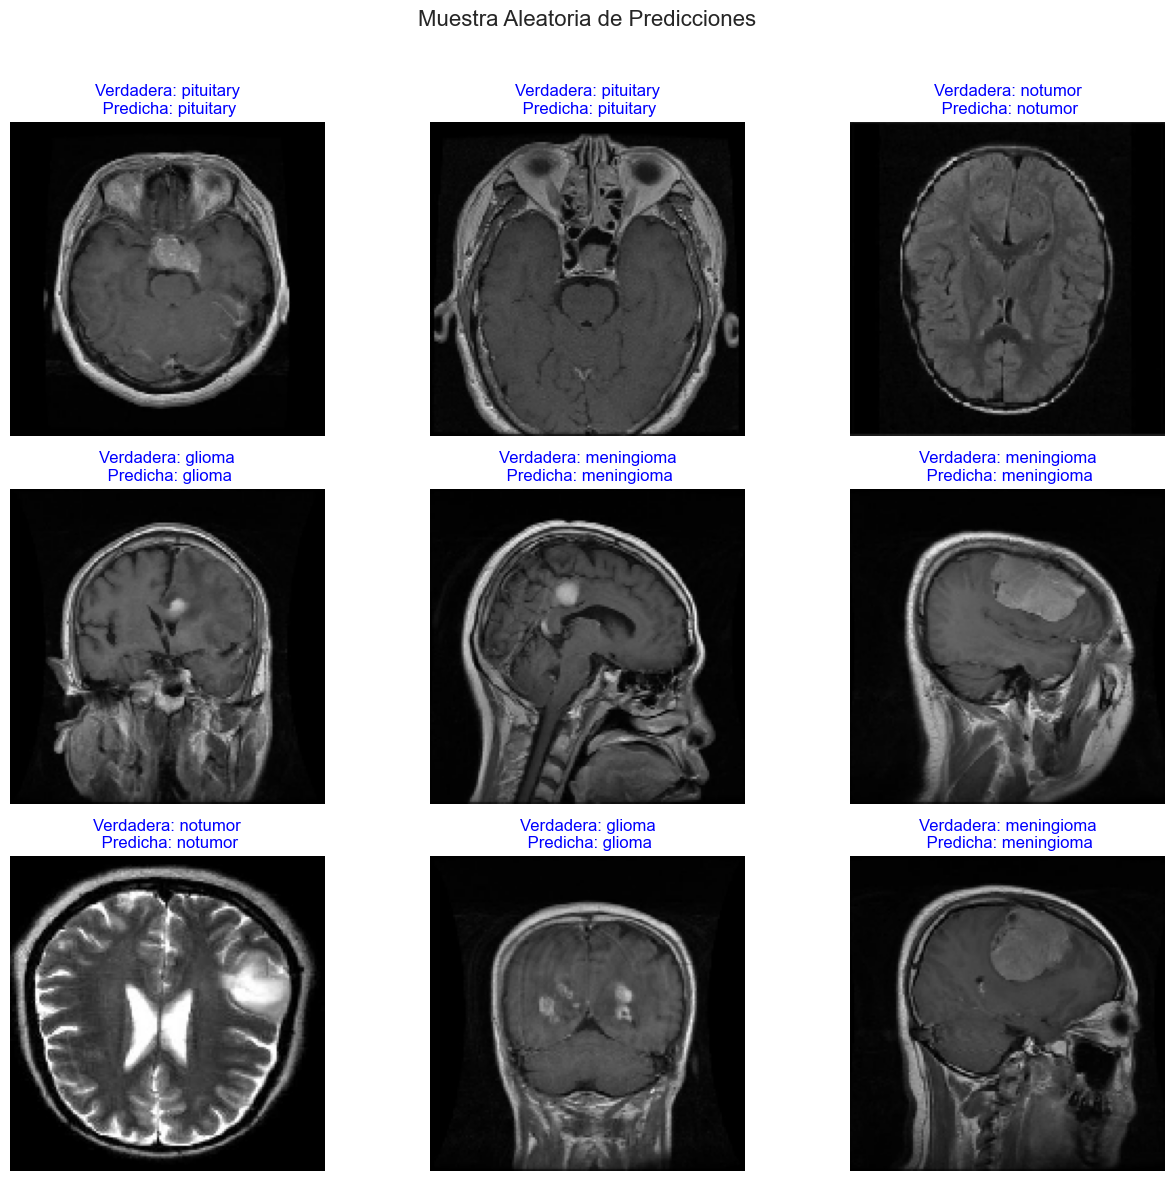

41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step

Se encontraron 24 predicciones incorrectas


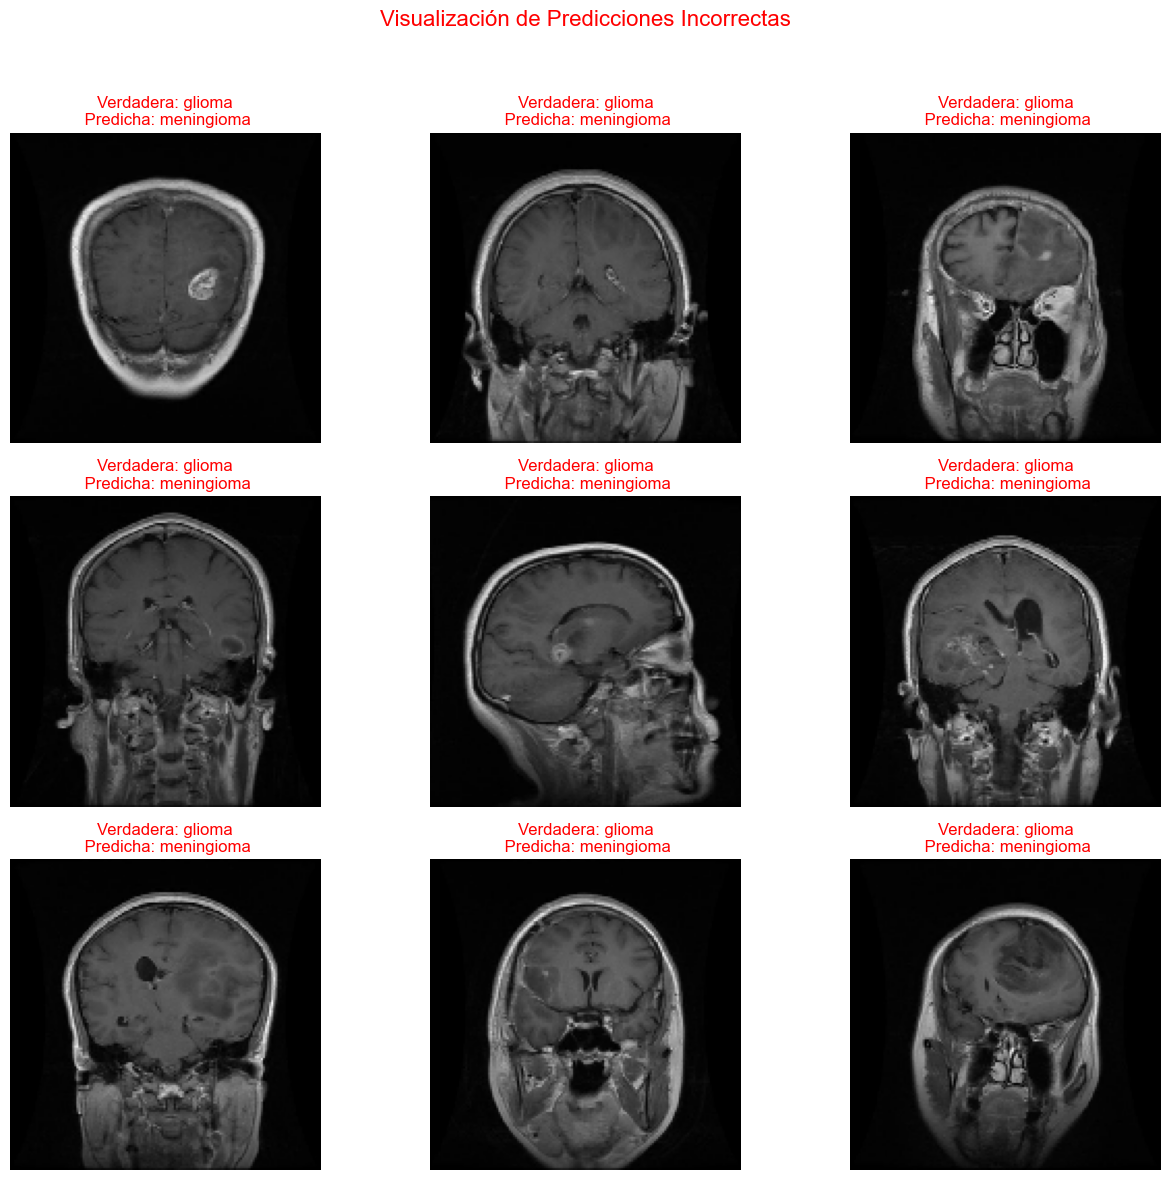

In [17]:
# 1. Mostrar una muestra aleatoria de 9 predicciones del conjunto de prueba
plot_sample_predictions(model=loaded_model, 
                        test_generator=testing_set, 
                        num_samples=9)

# 2. Mostrar todas las imágenes que el modelo clasificó incorrectamente
visualize_misclassified_images(model=loaded_model, 
                               test_generator=testing_set)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
Visualizando mapas de activación para la imagen: Te-pi_0012.jpg


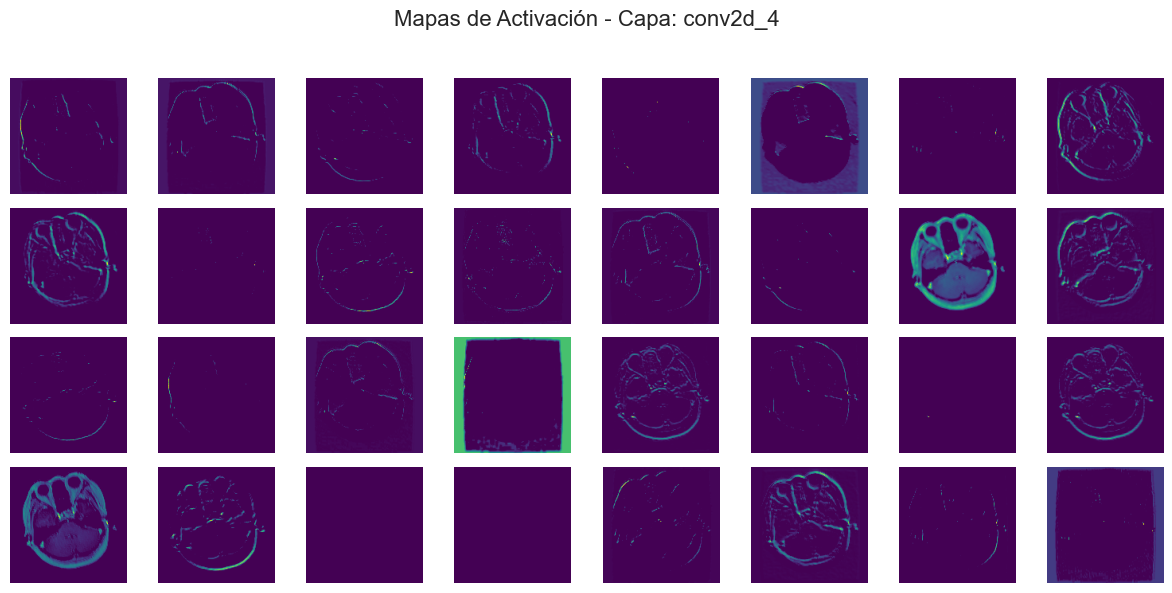

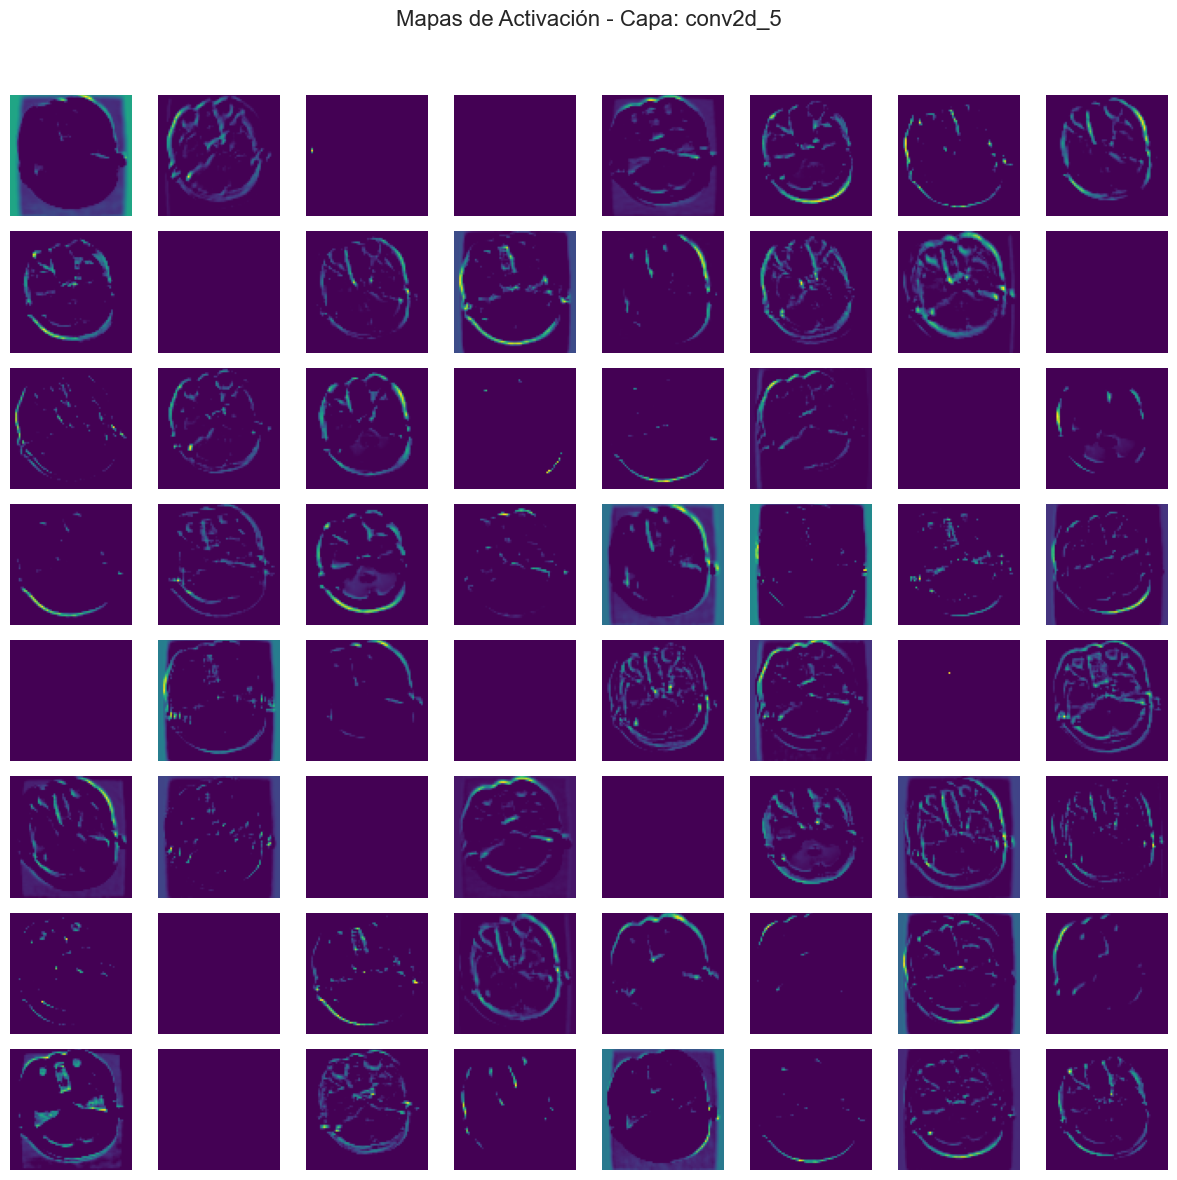

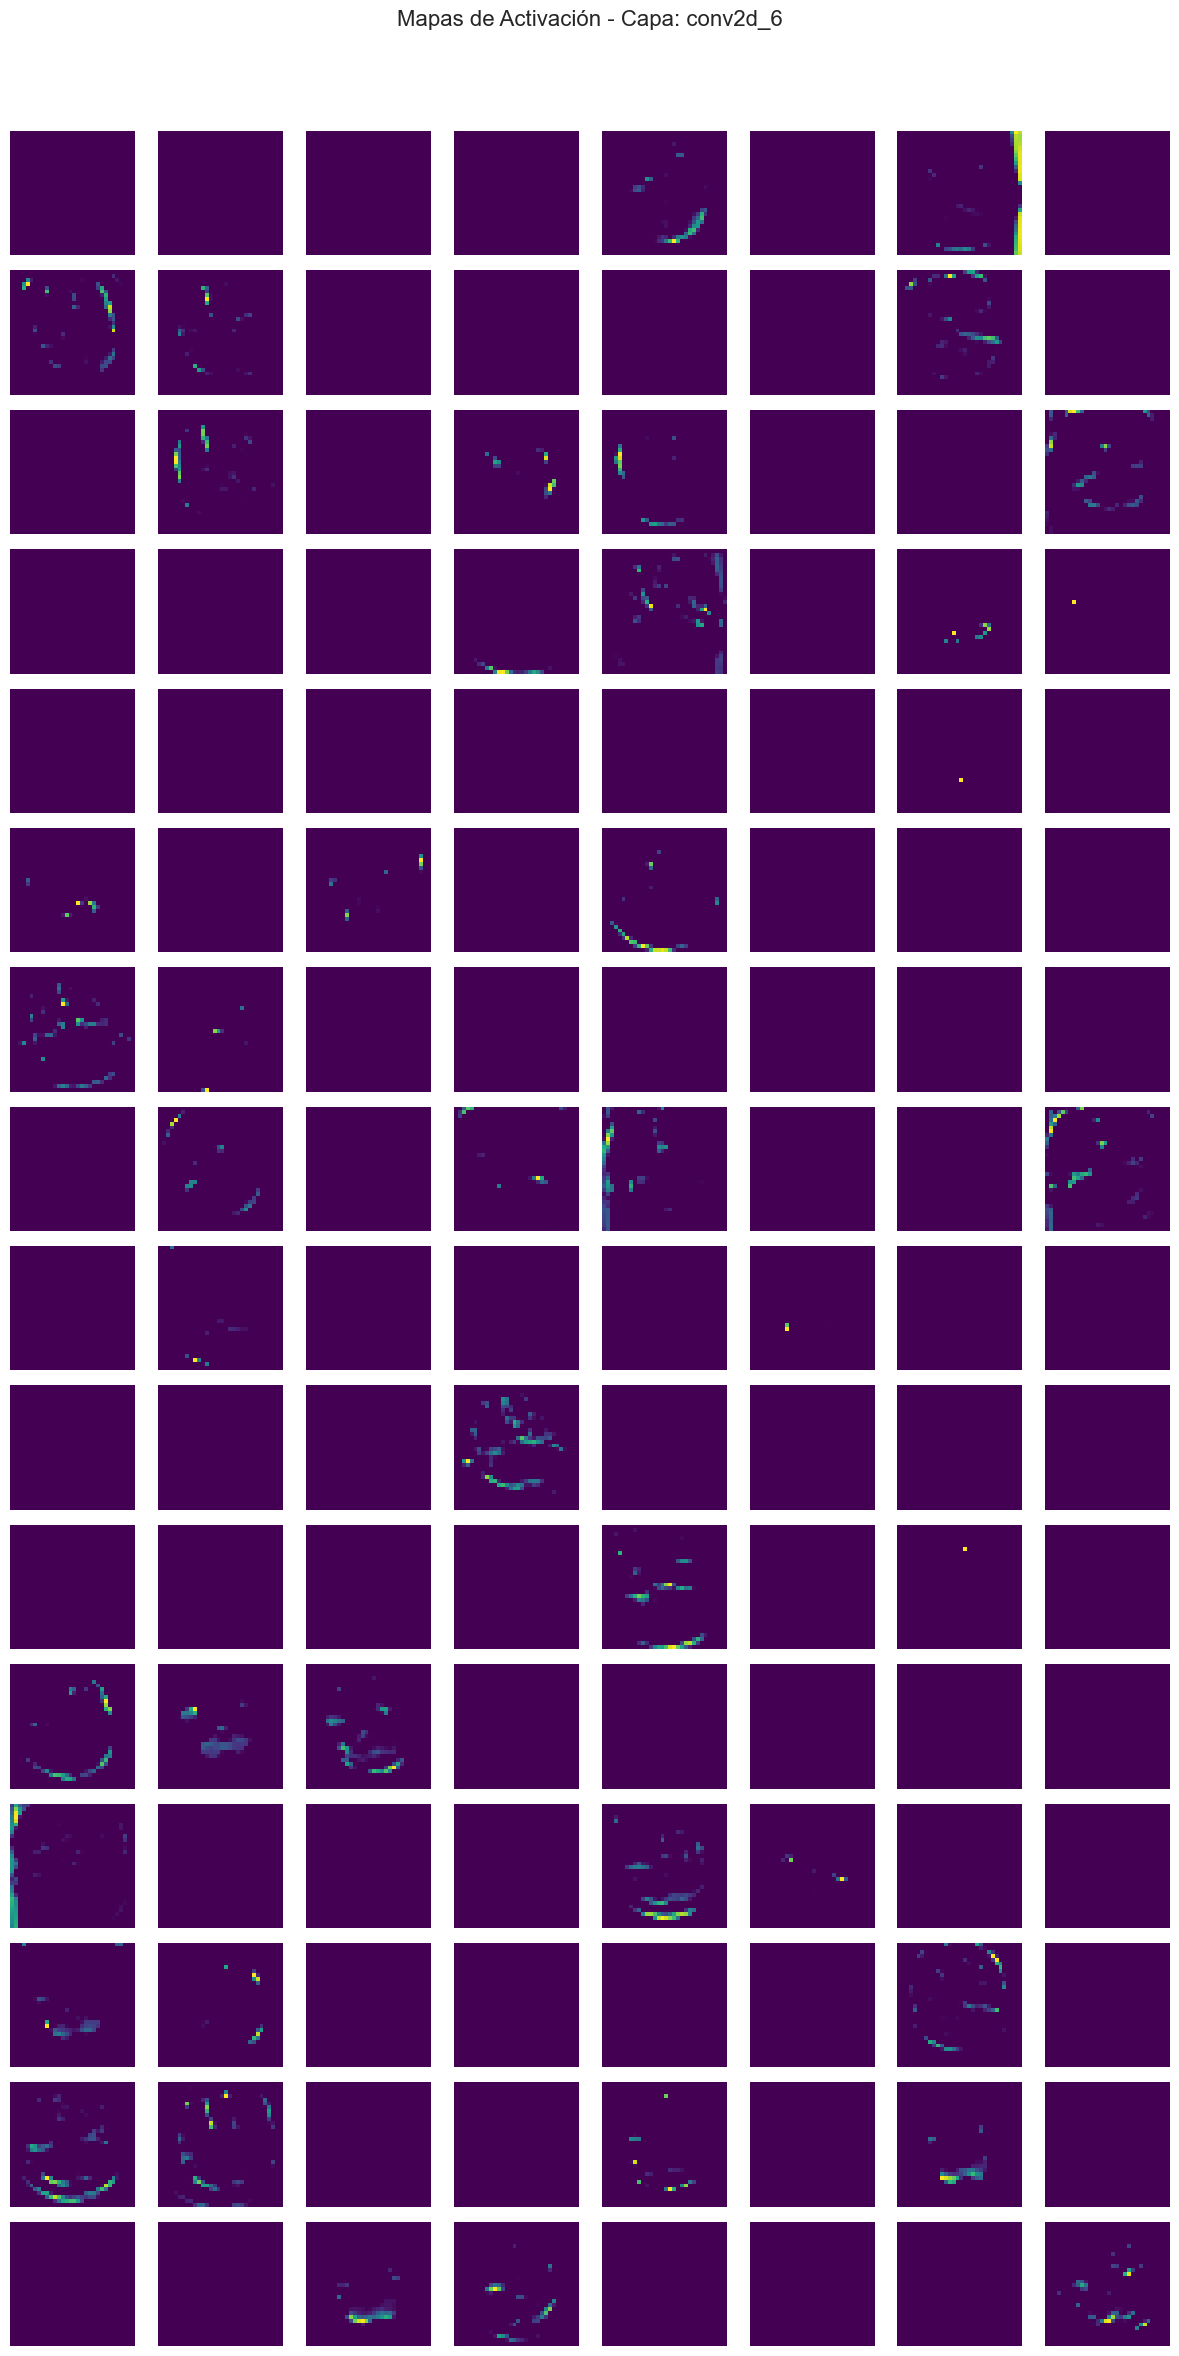

In [18]:
def visualize_activation_maps(model, image_path, N=5):
    # 1. Cargar y preprocesar la imagen de entrada
    img = load_img(image_path, target_size=(150, 150))
    img_tensor = img_to_array(img)
    img_tensor = np.expand_dims(img_tensor, axis=0)
    img_tensor /= 255.0

    # 2. Extraer las N primeras capas convolucionales del modelo
    conv_layers = [layer for layer in model.layers if 'conv2d' in layer.name.lower()][:N]
    if not conv_layers:
        print("No se encontraron capas convolucionales en el modelo.")
        return
        
    layer_outputs = [layer.output for layer in conv_layers]
    
    # 3. Crear un modelo que devuelve las activaciones de estas capas
    activation_model = tf.keras.models.Model(inputs=model.inputs, outputs=layer_outputs)

    # 4. Obtener los mapas de activación
    activations = activation_model.predict(img_tensor)

    # 5. Visualizar los mapas de activación
    print(f"Visualizando mapas de activación para la imagen: {image_path.split('/')[-1]}")
    
    for layer_name, layer_activation in zip([l.name for l in conv_layers], activations):
        n_features = layer_activation.shape[-1]  # Número de filtros en la capa
        size = layer_activation.shape[1]         # Tamaño del mapa de características
        
        # Configurar la cuadrícula para el plot
        n_cols = 8
        n_rows = n_features // n_cols
        
        plt.figure(figsize=(n_cols * 1.5, n_rows * 1.5))
        plt.suptitle(f"Mapas de Activación - Capa: {layer_name}", fontsize=16)
        
        for i in range(n_features):
            plt.subplot(n_rows, n_cols, i + 1)
            # Extraer el mapa de activación para el filtro i y mostrarlo
            feature_map = layer_activation[0, :, :, i]
            plt.imshow(feature_map, cmap='viridis')
            plt.axis('off')
            
        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()

# --- Llamada a la función ---
sample_image_path = 'Testing/pituitary/Te-pi_0012.jpg' 

visualize_activation_maps(model=loaded_model, image_path=sample_image_path, N=4)